# COMP7404 Computational intelligence and machine learning

# Group Project - Peer Teaching - Demo

# Detailed Instructions - Preparations need to be done before running demo

#### 1. download GroupProject_GroupN.zip from GitHub and unzip it

#### 2. go to the link below and download MHEALTHDATASET.zip
#### http://archive.ics.uci.edu/ml/machine-learning-databases/00319/

#### 3. unzip  MHEALTHDATASET.zip, then copy all 10 data files (mHealth_subjectX.log where X from 1 to 10) to the folder "GroupProject_GroupN"

#### 4. make sure packages including numpy, scipy, fastdtw, collections, plyfile, mpl_toolkits.mplot3d, matplotlib and sklearn are installed

#### 5. Python 3.6 is used

#### 6. go to GroupProject_GroupN folder and open jupyter notebook named "Wearable Devices using Dynamic Time Warping.ipynb" to run the demo



# Classes have been designed to manage datasets and algorithm logic
## superclass: dataset

### subclass:trainset
### subclass:testset
### subclass:masterset
    
## superclass: Experiment
### subclass:DTWExperiment

In [1]:
import pandas as pd
import math

class dataset(object):
    def __init__(self, data):
        self._data = data
    
    def get_data(self):
        return self._data
    
    def get_data_by_rows(self, no_of_rows):
        return self._data[0:no_of_rows]
    
    
    def data_cleaning(self):
        
#         print('before dropping na', self._data.shape)
#         self._data.dropna(axis = 0, how='any', inplace = True)
#         print('after dropping na', self._data.shape)
        
        print('before cleaning', self._data.Label.unique())
        self._data = self._data[self._data['Label'] != 0]
        print('after cleaning', self._data.Label.unique())


        
    def data_selected_features(self, selectedFeatures):
        print('before features selected', self._data.columns.unique())
        self._data = self._data[selectedFeatures]
        print('after features selected', self._data.columns.unique())
        
    
    def data_selected_labels(self, selectedLabels):
        print('before labels selected', self._data.Label.unique())
        self._data = self._data[self._data['Label'].isin(selectedLabels)]
        print('after labels selected', self._data.Label.unique())

        
    def get_selected_labels(self):
        return self._data['Label'].unique()
    
    def get_selected_subjects(self):
        return self._data['Subject'].unique()
    
    
    def get_XY(self):
        X = self._data.drop(['Label','Subject'], axis = 1)
        Y = self._data['Label']
        
        return X, Y
    
    def get_X_by_subject_label(self, subject, label, no_of_rows):
        X = self._data[(self._data['Subject']==subject) & (self._data['Label']==label)][0:no_of_rows]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_subject_label(self, subject, label, subsample):
        X = self._data[(self._data['Subject']==subject) & (self._data['Label']==label)][::subsample]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_label(self, label, no_of_rows):
        X = self._data[self._data['Label']==label][0:no_of_rows]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_label(self, label, subsample):
        X = self._data[self._data['Label']==label][::subsample]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_subject(self):
        return self._data['Subject']
    
    def set_data(self, data):
        self._data = data
    
#     def exportToCSV(self, file_name):
#         self._data.to_csv(file_name, index = False)
    
    
    def addThetaColumns(self, columnName):
        thetaXZ, thetaYZ = self.getThetaColumns(columnName)
        self._data[columnName + 'ThetaXZ'] = thetaXZ
        self._data[columnName + 'ThetaYZ'] = thetaYZ
        
    def addAllThetaColumns(self):
        self.addThetaColumns('AccelerationChest')
        self.addThetaColumns('AccelerationAnkle')
        self.addThetaColumns('GyroAnkle')
        self.addThetaColumns('MagnetometerAnkle')
        self.addThetaColumns('AccelerationArm')
        self.addThetaColumns('GyroArm')
        self.addThetaColumns('MagnetometerArm')
        
    
    def getThetaColumns(self, columnName):
        thetaXZ = []
        thetaYZ = []
        for row in range(0, self.get_data().shape[0]):
#             print(row)
            x = self.get_data()[columnName + 'X'].iloc[row]
            y = self.get_data()[columnName + 'Y'].iloc[row]
            z = self.get_data()[columnName + 'Z'].iloc[row]
            
            
#             print(x)
#             print(y)
#             print(z)
            
            tempThetaXZ, tempThetaYZ = self.convertToAngles(x, y, z)
            thetaXZ.append(tempThetaXZ)
            thetaYZ.append(tempThetaYZ)
#             print(thetaXZ[row])
#             print(thetaYZ[row])
        
        return thetaXZ, thetaYZ
    
# = ["AccelerationChestX"
# , "AccelerationChestY"
# , "AccelerationChestZ"
# , "ElectrocardiogramLead1"
# , "ElectrocardiogramLead2"
# , "AccelerationAnkleX"
# , "AccelerationAnkleY"
# , "AccelerationAnkleZ"
# , "GyroAnkleX"
# , "GyroAnkleY"
# , "GyroAnkleZ"
#                 , "MagnetometerAnkleX"
#                 , "MagnetometerAnkleY"
#                 , "MagnetometerAnkleZ"
# , "AccelerationArmX"
# , "AccelerationArmY"
# , "AccelerationArmZ"
# , "GyroArmX"
# , "GyroArmY"
# , "GyroArmZ"
# , "MagnetometerArmX"
# , "MagnetometerArmY"
# , "MagnetometerArmZ"
# , "Label"
# ]

    def unit_vector(self, vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    
    def angle_between(self, v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'::

                >>> angle_between((1, 0, 0), (0, 1, 0))
                1.5707963267948966
                >>> angle_between((1, 0, 0), (1, 0, 0))
                0.0
                >>> angle_between((1, 0, 0), (-1, 0, 0))
                3.141592653589793
        """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    
    def convertToAngles(self, x, y, z):
        # X-Z Plane, v2.Y must be zero
        v1 = [x, y, z]
        v2 = [x, 0, z]

        if y >= 0 and z >= 0:
            thetaXZ = math.degrees(self.angle_between(v1, v2))
        elif y >= 0 and z <= 0:
            thetaXZ = 180 - math.degrees(self.angle_between(v1, v2))   
        elif y <= 0 and z <= 0:
            thetaXZ = 180 + math.degrees(self.angle_between(v1, v2))
        elif y <= 0 and z >= 0:
            thetaXZ = 360 - math.degrees(self.angle_between(v1, v2))


        # Y-Z Plane, v2.X must be zero
        v1 = [x, y, z]
        v2 = [0, y, z]

        if x >= 0 and z >= 0:
            thetaYZ = math.degrees(self.angle_between(v1, v2))
        elif x >= 0 and z <= 0:
            thetaYZ = 180 - math.degrees(self.angle_between(v1, v2))   
        elif x <= 0 and z <= 0:
            thetaYZ = 180 + math.degrees(self.angle_between(v1, v2))
        elif x <= 0 and z >= 0:
            thetaYZ = 360 - math.degrees(self.angle_between(v1, v2))

        return thetaXZ, thetaYZ

In [2]:
class trainset(dataset):
    def __init__(self):
        
        for i in range(1, 9):
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            print(i)
            if i == 1:
                subject['Subject'] = i
                train_subjects = subject
            else:
                subject['Subject'] = i
                train_subjects = pd.concat([train_subjects, subject])

        
        
        super().__init__(train_subjects)

In [3]:
class testset(dataset):
    def __init__(self, subject_index_list):
        count = 0
        for i in subject_index_list:
            count = count + 1
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            print(i)
            subject['Subject'] = i
            
            if count == 1:    
                test_subjects = subject
            else:
                test_subjects = pd.concat([test_subjects, subject])
        
            
        super().__init__(test_subjects)

In [4]:
class masterset(dataset):
    def __init__(self, subject_index_list):
        count = 0
        for i in subject_index_list:
            count = count + 1
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            
            print(i)
            subject['Subject'] = i

            if count == 1:
                train_subjects = subject
            else:
                train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [5]:
class exportset(dataset):
    def __init__(self, subject_index):
        
#         for i in range(1, 9):
        subject = pd.read_csv('mHealth_subject' + str(subject_index) + '.log', sep="\t", header=None)
        subject.columns = ["AccelerationChestX"
                        , "AccelerationChestY"
                        , "AccelerationChestZ"
                        , "ElectrocardiogramLead1"
                        , "ElectrocardiogramLead2"
                        , "AccelerationAnkleX"
                        , "AccelerationAnkleY"
                        , "AccelerationAnkleZ"
                        , "GyroAnkleX"
                        , "GyroAnkleY"
                        , "GyroAnkleZ"
                        , "MagnetometerAnkleX"
                        , "MagnetometerAnkleY"
                        , "MagnetometerAnkleZ"
                        , "AccelerationArmX"
                        , "AccelerationArmY"
                        , "AccelerationArmZ"
                        , "GyroArmX"
                        , "GyroArmY"
                        , "GyroArmZ"
                        , "MagnetometerArmX"
                        , "MagnetometerArmY"
                        , "MagnetometerArmZ"
                        , "Label"
                       ]

#             print(i)
#             if i == 1:
        subject['Subject'] = subject_index
        train_subjects = subject
#             else:
#                 subject['Subject'] = i
#                 train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [6]:
class importset(dataset):
    def __init__(self, subject_index_list):
        
        count = 0
        for i in subject_index_list:
            print('importing subject = ', i)
            count = count + 1
            subject = pd.read_csv('subject' + str(i) + '.csv')

            if count == 1:
                train_subjects = subject
            else:
                train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [7]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Experiment(object):
    def __init__(self, masterset, testset):
        self._masterset = masterset
        self._testset = testset
        self._masterset_copy = masterset
        self._testset_copy = testset
        
    def restoringDataset(self):
        self._masterset = self._masterset_copy
        self._testset = self._testset_copy
    
    def get_masterset(self):
        return self._masterset
    
    def get_testset(self):
        return self._testset
    
    def Scaling(self, preprocessor):
        X_train, y_train = self._masterset.get_XY()
        X_test, y_test = self._testset.get_XY()
        
        preprocessor.fit(X_train)
        
        X_train_scaled = pd.DataFrame(preprocessor.transform(X_train))
        X_test_scaled = pd.DataFrame(preprocessor.transform(X_test))
        
        X_train_scaled.columns = list(self._masterset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        X_test_scaled.columns = list(self._testset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        
        print(X_train_scaled.shape)
        print(self._masterset.get_subject().shape)
        X_train_scaled['Subject'] = list(self._masterset.get_subject())
        X_train_scaled['Label'] = list(y_train)
        
        self._masterset.set_data(X_train_scaled)
        self._masterset.get_data()
        
        X_test_scaled['Subject'] = list(self._testset.get_subject())
        X_test_scaled['Label'] = list(y_test)
        
        self._testset.set_data(X_test_scaled)
        self._testset.get_data()
    
    
    
    def doPCA(self, data, dimensions=2):

        model = PCA(n_components=dimensions)
        model.fit(data)
        print(model.explained_variance_ratio_)
        print(model.explained_variance_)
        print ("Cummulative Variance Explained = ", (np.sum(model.explained_variance_ratio_)))

        print(model.explained_variance_)

        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
        
        
        suggestedDimensions = 0
        for suggestedDimensions in range(0, len(model.explained_variance_)):
            if model.explained_variance_[suggestedDimensions] >= 1:
                suggestedDimensions = suggestedDimensions + 1
                print('suggestedDimensions',suggestedDimensions)
            else:
                suggestedDimensions = suggestedDimensions - 1
                print('suggestedDimensions',suggestedDimensions)
                break

        # print "Suggested Dimensions = %d" % suggestedDimensions

        return suggestedDimensions, model
    
    
    
    def ReducingDimensionByPCA(self):
        X_train, y_train = self._masterset.get_XY()
        X_test, y_test = self._testset.get_XY()
        
        suggestedDimensions, pca = self.doPCA(data = X_train, dimensions = X_train.shape[1])
        suggestedDimensions, pca = self.doPCA(data = X_train, dimensions = suggestedDimensions)
        
        X_train_trans = pd.DataFrame(pca.transform(X_train))
        X_test_trans = pd.DataFrame(pca.transform(X_test))
        
#         preprocessor.fit(X_train)
        
#         X_train_scaled = pd.DataFrame(preprocessor.transform(X_train))
#         X_test_scaled = pd.DataFrame(preprocessor.transform(X_test))
        
#         X_train_scaled.columns = list(self._masterset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
#         X_test_scaled.columns = list(self._testset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        
    
        print(X_train_trans.shape)
        print(self._masterset.get_subject().shape)
        X_train_trans['Subject'] = list(self._masterset.get_subject())
        X_train_trans['Label'] = list(y_train)
        
        self._masterset.set_data(X_train_trans)
        self._masterset.get_data()
        
        X_test_trans['Subject'] = list(self._testset.get_subject())
        X_test_trans['Label'] = list(y_test)
        
        self._testset.set_data(X_test_trans)
        self._testset.get_data()
    
    

In [8]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from collections import Counter


class DTWExperiment(Experiment):
    def __init__(self, master, test):
        super().__init__(master, test)
        
    def classifyOneMovementWithoutSelectMasterSubject(self, testsubject_index, testsubject_action_index, subsample):
        dtw_result = []
#         no_of_rows = 10000
#         testsubject_action_index = 10

        for master_action_index in range(1, 13):
            X_master = self._masterset.get_X_by_label(master_action_index, subsample)
            X_test = self._testset.get_X_by_subject_label(testsubject_index, testsubject_action_index, subsample)
            
            distance, path = fastdtw(X_master, X_test, dist=euclidean)
            dtw_result.append((testsubject_index, testsubject_action_index, master_action_index, distance))

        dtw_result_df = pd.DataFrame(list(dtw_result), columns = ['TestSubject', 'TestSubjectAction', 'MasterSetAction', 'Distance'])

        isMinDistance = np.zeros(len(dtw_result_df))
        isCorrect = np.zeros(len(dtw_result_df))

        for row_index in range(0, 12):
        #     print(dtw_result_df.iloc[row_index]['Distance'])

            if dtw_result_df.iloc[row_index]['Distance'] == dtw_result_df['Distance'].min():
                isMinDistance[row_index] = 1
                if dtw_result_df.iloc[row_index]['TestSubjectAction'] == dtw_result_df.iloc[row_index]['MasterSetAction']:
                    isCorrect[row_index] = 1

        dtw_result_df['isMinDistance'] = isMinDistance
        dtw_result_df['isCorrect'] = isCorrect
        
        return dtw_result_df
    
    
    def classifyOneMovement(self, mastersubject_index, testsubject_index, testsubject_action_index, subsample):
        dtw_result = []
#         no_of_rows = 10000
#         testsubject_action_index = 10

        for master_action_index in self._masterset.get_selected_labels():
#             X_master = self._masterset.get_X_by_label(master_action_index, no_of_rows)
            X_master = self._masterset.get_X_by_subject_label(mastersubject_index, master_action_index, subsample)            
            X_test = self._testset.get_X_by_subject_label(testsubject_index, testsubject_action_index, subsample)
            
            distance, path = fastdtw(X_master, X_test, dist=euclidean)
            dtw_result.append((mastersubject_index, testsubject_index, testsubject_action_index, master_action_index, distance))

        dtw_result_df = pd.DataFrame(list(dtw_result), columns = ['MasterSubject', 'TestSubject', 'TestSubjectAction', 'MasterSetAction', 'Distance'])

        isMinDistance = np.zeros(len(dtw_result_df))
        isCorrect = np.zeros(len(dtw_result_df))

        for row_index in range(0, len(self._masterset.get_selected_labels())):

            if dtw_result_df.iloc[row_index]['Distance'] == dtw_result_df['Distance'].min():
                isMinDistance[row_index] = 1
                if dtw_result_df.iloc[row_index]['TestSubjectAction'] == dtw_result_df.iloc[row_index]['MasterSetAction']:
                    isCorrect[row_index] = 1

        dtw_result_df['isMinDistance'] = isMinDistance
        dtw_result_df['isCorrect'] = isCorrect
        
        return dtw_result_df
    
    def classifyOneMovementByAllMasterSubjects(self, testsubject_index, testsubject_action_index, subsample):
        count = 0
        for mastersubject_index in self._masterset.get_selected_subjects():
            count = count + 1
            tempDf = self.classifyOneMovement(mastersubject_index, testsubject_index, testsubject_action_index, subsample)
            
            if count == 1:
                resultDf = tempDf
            else:
                resultDf = pd.concat([resultDf, tempDf])
                
        return resultDf
            
    def predictOneMovementByVoting(self, testsubject_index, testsubject_action_index, subsample):
        resultDf = self.classifyOneMovementByAllMasterSubjects(testsubject_index, testsubject_action_index, subsample)
        
        c = Counter(resultDf[resultDf['isMinDistance'] == 1]['MasterSetAction'])
        freq = c.most_common(8)
        predictedAction = freq[0][0]
        
        if testsubject_action_index == predictedAction:
            predictedResult = True
        else:
            predictedResult = False
        
        return predictedAction, predictedResult
    
    def predictOneMovement(self, testsubject_index, testsubject_action_index, subsample):
        resultDf = self.classifyOneMovementByAllMasterSubjects(testsubject_index, testsubject_action_index, subsample)
        
#         c = Counter(resultDf[resultDf['isMinDistance'] == 1]['MasterSetAction'])
#         freq = c.most_common(8)
#         predictedAction = freq[0][0]
        
        predictedAction = resultDf[['MasterSetAction','Distance']].groupby(by="MasterSetAction").mean().idxmin().values[0]
        
#         print(testsubject_action_index)
#         print(predictedAction)
#         print(testsubject_action_index == predictedAction)
        if testsubject_action_index == predictedAction:
            predictedResult = True
        else:
            predictedResult = False
        
        return predictedAction, predictedResult
   


 #     def PredictAllMovements(self
#                            , start_test_subject_index
#                            , end_test_subject_index
#                            , start_test_subject_action_index
#                            , end_test_subject_action_index
#                            , no_of_rows):
# #         no_of_rows = 100

#         predicted_all = []

#         for testsubject_index in range(start_test_subject_index, end_test_subject_index + 1):
#             for testsubject_action_index in range(start_test_subject_action_index, end_test_subject_action_index + 1):
#                 predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index
#                                                                                       , testsubject_action_index
#                                                                                       , no_of_rows)

#                 predicted_all.append((testsubject_index, testsubject_action_index, predictedAction, predictedResult))
        
#         resultDf = pd.DataFrame(list(predicted_all), columns = ['TestSubject', 'ActualAction', 'PredictedAction', 'Result'])
#         accuracy = len(resultDf[resultDf['Result']==True]) * 1.0 / len(resultDf)
        
#         return resultDf, accuracy
    
    def PredictAllMovements(self
                           , test_subject_index_list
                           , test_subject_action_index_list
                           , subsample):
#         no_of_rows = 100

        predicted_all = []

        for testsubject_index in test_subject_index_list:
            for testsubject_action_index in test_subject_action_index_list:
                predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index
                                                                                      , testsubject_action_index
                                                                                      , subsample)

                predicted_all.append((testsubject_index, testsubject_action_index, predictedAction, predictedResult))
        
        resultDf = pd.DataFrame(list(predicted_all), columns = ['TestSubject', 'ActualAction', 'PredictedAction', 'Result'])
        accuracy = len(resultDf[resultDf['Result']==True]) * 1.0 / len(resultDf)
        
        return resultDf, accuracy
    

# Initialize master and test dataset objects

# Split Dataset

### - Time series data - split by subject instead of randomly splitting​

### - Assign 8 people to Master Set​ & 2 people to Test Set​

### - Subjects must be assigned separately to either Master or Test Set

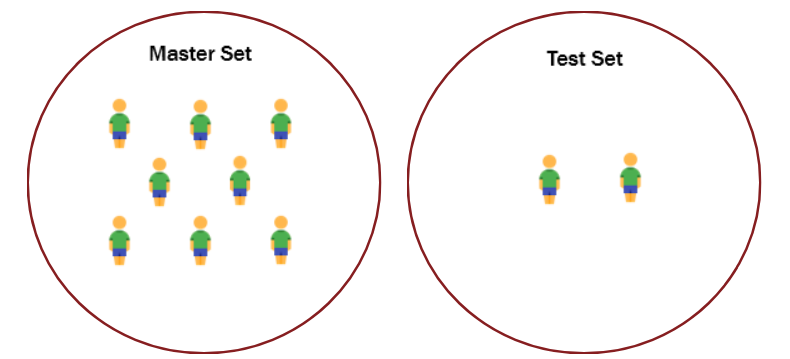

# assign subjects 1 - 8 to Master Set & 9 - 10 to Test Set​

In [9]:
master = masterset(subject_index_list = [1, 2, 3, 4, 5, 6, 7, 8])

1
2
3
4
5
6
7
8


In [10]:
test = testset(subject_index_list = [9, 10])

9
10


# Data cleaning: remove idle action = 0

![title](img/datacleaning.png)

In [11]:
master.data_cleaning()

before cleaning [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
after cleaning [ 1  2  3  4  6  7  8  9 10 11 12  5]


In [12]:
test.data_cleaning()

before cleaning [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
after cleaning [ 1  2  3  4  6  7  8  9 10 11 12  5]


# Dataset Description

2) Activity set

The activity set is listed in the following:

L1: Standing still (1 min) 
L2: Sitting and relaxing (1 min) 
L3: Lying down (1 min) 
L4: Walking (1 min) 
L5: Climbing stairs (1 min) 
L6: Waist bends forward (20x) 
L7: Frontal elevation of arms (20x)
L8: Knees bending (crouching) (20x)
L9: Cycling (1 min)
L10: Jogging (1 min)
L11: Running (1 min)
L12: Jump front & back (20x)

# masterset and testset rows and columns are as follows: 
### 25 columns, 23 are features
### Label = subjects movement
### subject = subject identity

![title](img/datadescription.png)

# The code to get dataset descriptive figures is as follows

# Master and test datasets size

In [13]:
master.get_data().shape

(275151, 25)

In [14]:
test.get_data().shape

(68044, 25)

# Original features in master and test sets

In [15]:
master.get_data().columns

Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')

# You can select any variables you want as features (Label and Subject columns must be included).  All original features in XYZ as well as Label and Subject are selected in our case

In [16]:
master.data_selected_features(['Label', 'Subject','AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ'
       ])

before features selected Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')
after features selected Index(['Label', 'Subject', 'AccelerationChestX', 'AccelerationChestY',
       'AccelerationChestZ', 'ElectrocardiogramLead1',
       'ElectrocardiogramLead2', 'AccelerationAnkleX', 'AccelerationAnkleY',
       'AccelerationAnkleZ', 'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ',
       'MagnetometerAnkleX', 'MagnetometerAnkleY', 'MagnetometerAnkleZ',
       'AccelerationArmX', 'AccelerationArmY', 'Accelerat

In [17]:
test.data_selected_features(['Label', 'Subject','AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ'
       ])

before features selected Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')
after features selected Index(['Label', 'Subject', 'AccelerationChestX', 'AccelerationChestY',
       'AccelerationChestZ', 'ElectrocardiogramLead1',
       'ElectrocardiogramLead2', 'AccelerationAnkleX', 'AccelerationAnkleY',
       'AccelerationAnkleZ', 'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ',
       'MagnetometerAnkleX', 'MagnetometerAnkleY', 'MagnetometerAnkleZ',
       'AccelerationArmX', 'AccelerationArmY', 'Accelerat

# First 5 observations of master and test sets

In [18]:
master.get_data().head()

Label  Subject  AccelerationChestX  AccelerationChestY  \
6656      1        1             -9.7788             0.55690   
6657      1        1             -9.7733             0.27880   
6658      1        1             -9.8609             0.11561   
6659      1        1             -9.7409             0.17652   
6660      1        1             -9.7821             0.21637   

      AccelerationChestZ  ElectrocardiogramLead1  ElectrocardiogramLead2  \
6656             1.19750                0.008373               -0.033490   
6657             0.73036               -0.025118               -0.025118   
6658             0.79988                0.025118                0.016745   
6659             0.88957                0.180010                0.129770   
6660             0.90368                0.092098                0.046049   

      AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
6656              2.6493             -9.4517             0.37683   
6657              2.4157             -9.5306             0.40179   
6658              2.3865             -9.5991             0.48141   
6659              2.3758             -9.5997             0.42919   
6660              2.3239             -9.5406             0.40038   

            ...         MagnetometerAnkleZ  AccelerationArmX  \
6656        ...                   -0.73822           -2.8439   
6657        ...                   -0.88628           -2.9935   
6658        ...                   -1.01980           -2.8846   
6659        ...                   -1.17150           -2.9245   
6660        ...                   -0.88628           -2.8963   

      AccelerationArmY  AccelerationArmZ  GyroArmX  GyroArmY  GyroArmZ  \
6656           -9.0618            1.8177 -0.058824  -0.93429  -0.34483   
6657           -9.2048            1.5189 -0.058824  -0.93429  -0.34483   
6658           -9.1945            1.5507 -0.058824  -0.93429  -0.34483   
6659           -9.1746            1.5413 -0.078431  -0.93429  -0.34052   
6660           -9.2039            1.6127 -0.078431  -0.93429  -0.34052   

      MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  
6656          0.355370          -0.37003          -0.35020  
6657          0.719910           0.17803           0.37363  
6658          0.355370          -0.37003          -0.35020  
6659          0.357180          -0.18858          -0.35198  
6660         -0.001887          -0.18867          -0.72017  

[5 rows x 25 columns]

In [19]:
test.get_data().head()

Label  Subject  AccelerationChestX  AccelerationChestY  \
12288      1        9             -9.4805             -1.7301   
12289      1        9             -9.4886             -1.8315   
12290      1        9             -9.9525             -1.8703   
12291      1        9             -9.5801             -1.8014   
12292      1        9             -9.2542             -1.9377   

       AccelerationChestZ  ElectrocardiogramLead1  ElectrocardiogramLead2  \
12288            -0.10308               -0.753530               -0.502350   
12289            -0.08062               -0.288850               -0.125590   
12290             0.30536               -0.041863               -0.004186   
12291            -0.15160                0.025118                0.037677   
12292            -0.33229                0.092098                0.092098   

       AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
12288             0.79065             -9.7829             0.91459   
12289             0.80350             -9.9303             1.03240   
12290             0.71974             -9.7724             0.97691   
12291             0.75194             -9.9608             0.94698   
12292             0.73087             -9.8915             0.95023   

             ...         MagnetometerAnkleZ  AccelerationArmX  \
12288        ...                   -0.44769           -2.7267   
12289        ...                   -0.58122           -2.7424   
12290        ...                   -0.29787           -2.7871   
12291        ...                   -0.58481           -2.9003   
12292        ...                   -0.44410           -2.9607   

       AccelerationArmY  AccelerationArmZ  GyroArmX  GyroArmY  GyroArmZ  \
12288           -9.0376            1.2356  -0.80784  -0.70226  -0.15302   
12289           -9.3879            1.2077  -0.80784  -0.70226  -0.15302   
12290           -8.9777            1.2282  -0.80784  -0.68994  -0.15948   
12291           -9.2391            1.0901  -0.80784  -0.68994  -0.15948   
12292           -9.2091            1.0916  -0.80784  -0.68994  -0.15948   

       MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  
12288          0.008892           0.88921           -1.8138  
12289         -0.174250           0.52807           -1.8138  
12290          0.366180           0.71146           -1.0828  
12291          0.188370           0.88385           -2.1711  
12292          0.369740           1.06710           -1.8083  

[5 rows x 25 columns]

# Brief descriptive figures of master and test sets

In [20]:
master.get_data().describe()

Label        Subject  AccelerationChestX  AccelerationChestY  \
count  275151.000000  275151.000000       275151.000000       275151.000000   
mean        6.169147       4.445130           -7.521110           -0.143850   
std         3.294922       2.290791            5.756336            2.642278   
min         1.000000       1.000000          -22.438000          -20.188000   
25%         3.000000       2.000000           -9.730100           -1.188600   
50%         6.000000       4.000000           -8.831800           -0.290240   
75%         9.000000       6.000000           -5.347200            0.875830   
max        12.000000       8.000000           19.094000           20.917000   

       AccelerationChestZ  ElectrocardiogramLead1  ElectrocardiogramLead2  \
count       275151.000000           275151.000000           275151.000000   
mean            -0.699136                0.000503               -0.010255   
std              4.635464                0.902349                0.931583   
min            -18.401000               -8.619600               -8.619600   
25%             -3.463450               -0.230250               -0.188380   
50%             -0.642570               -0.075353               -0.050235   
75%              1.360550                0.175820                0.154890   
max             26.196000                8.506500                8.519100   

       AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
count       275151.000000       275151.000000       275151.000000   
mean             1.812238           -9.061107           -0.719000   
std              4.156885            5.181774            6.451024   
min            -22.146000          -19.619000          -19.373000   
25%              0.133210          -10.067000           -3.464600   
50%              1.449700           -9.585400            0.290490   
75%              2.927250           -7.490700            1.811800   
max             20.024000           21.161000           25.015000   

             ...         MagnetometerAnkleZ  AccelerationArmX  \
count        ...              275151.000000     275151.000000   
mean         ...                  -0.290972         -3.304465   
std          ...                  19.615009          5.937592   
min          ...                -282.390000        -22.345000   
25%          ...                  -1.798300         -4.897050   
50%          ...                  -0.297870         -2.300900   
75%          ...                   1.553900         -0.388945   
max          ...                 272.560000         19.801000   

       AccelerationArmY  AccelerationArmZ       GyroArmX       GyroArmY  \
count     275151.000000     275151.000000  275151.000000  275151.000000   
mean          -5.836086          2.453024      -0.208735      -0.397540   
std            6.613616          4.288466       0.539642       0.557495   
min          -18.972000        -18.238000      -1.170600      -2.205300   
25%           -9.587100          0.353010      -0.641180      -0.833680   
50%           -7.748900          1.999100      -0.294120      -0.593430   
75%           -2.181600          5.234500       0.186270      -0.022587   
max           21.965000         25.741000       1.321600       1.121100   

            GyroArmZ  MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  
count  275151.000000     275151.000000     275151.000000     275151.000000  
mean        0.379569         -0.507261          1.569891          0.379133  
std         0.519960         34.443681         31.853086         84.864603  
min        -1.114200       -319.030000       -358.130000       -702.570000  
25%        -0.038793         -6.714850         -7.694150        -12.552000  
50%         0.454740          0.358960          0.353650         -0.494730  
75%         0.844830          5.524700          9.265950         11.233000  
max         1.528000        234.890000        335.250000        657.180000  

[8 rows x 25 columns]

In [21]:
test.get_data().describe()

Label       Subject  AccelerationChestX  AccelerationChestY  \
count  68044.000000  68044.000000        68044.000000        68044.000000   
mean       6.168509      9.495121           -7.340349           -0.129089   
std        3.314973      0.499980            5.474165            3.360574   
min        1.000000      9.000000          -22.296000          -20.021000   
25%        3.000000      9.000000           -9.619900           -1.883100   
50%        6.000000      9.000000           -8.583500           -0.303405   
75%        9.000000     10.000000           -4.636675            1.809825   
max       12.000000     10.000000           17.618000           20.927000   

       AccelerationChestZ  ElectrocardiogramLead1  ElectrocardiogramLead2  \
count        68044.000000            68044.000000            68044.000000   
mean            -1.906006                0.016370                0.000879   
std              4.380268                0.508203                0.448549   
min            -18.400000               -3.604400               -4.600700   
25%             -4.736775               -0.159080               -0.125590   
50%             -1.813650               -0.066981               -0.046049   
75%              0.131322                0.129770                0.092098   
max             10.562000                4.081600                4.684500   

       AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
count        68044.000000        68044.000000        68044.000000   
mean             1.776662           -9.063023           -0.633180   
std              4.438221            5.275032            6.483828   
min            -22.126000          -19.599000          -19.364000   
25%              0.226148          -10.052000           -3.582025   
50%              0.967950           -9.671100            0.487160   
75%              2.874200           -8.123975            1.930425   
max             20.014000           20.766000           24.400000   

             ...         MagnetometerAnkleZ  AccelerationArmX  \
count        ...               68044.000000      68044.000000   
mean         ...                  -0.739776         -4.029430   
std          ...                  15.665477          5.664786   
min          ...                -203.550000        -21.905000   
25%          ...                  -1.614625         -5.687100   
50%          ...                  -0.442260         -2.927200   
75%          ...                   1.624225         -1.532300   
max          ...                 179.730000         19.398000   

       AccelerationArmY  AccelerationArmZ      GyroArmX      GyroArmY  \
count      68044.000000      68044.000000  68044.000000  68044.000000   
mean          -5.560494          2.090584     -0.172617     -0.462985   
std            6.429193          3.683399      0.586904      0.495348   
min          -18.928000        -18.216000     -1.060800     -2.256700   
25%           -9.460075         -0.231200     -0.729410     -0.788500   
50%           -7.700900          1.052400     -0.386270     -0.613960   
75%           -2.422575          5.865700      0.409800     -0.123200   
max           21.807000         23.974000      1.415700      0.683780   

           GyroArmZ  MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  
count  68044.000000      68044.000000      68044.000000      68044.000000  
mean       0.385237         -0.635213          0.824676         -1.378418  
std        0.497859         33.280826         22.865112         73.070786  
min       -0.870690       -207.920000       -316.230000       -504.800000  
25%       -0.045259         -4.776800         -5.981300        -10.993000  
50%        0.443970          0.362620          0.355690         -0.716510  
75%        0.814660          4.213200          5.683050          7.157325  
max        1.377200        239.690000        221.010000        586.080000  

[8 rows x 25 columns]

# 12 Actions are included in the datasets

In [22]:
master.get_selected_labels()

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,  5], dtype=int64)

In [23]:
test.get_selected_labels()

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,  5], dtype=int64)

In [24]:
print(master.get_data().shape)
print(test.get_data().shape)

(275151, 25)
(68044, 25)


In [25]:
len(master.get_selected_labels())

12

# Number of observations of 12 actions for subject 9 and 10

In [26]:
test.get_data().groupby(by = ['Subject','Label']).count()

AccelerationChestX  AccelerationChestY  AccelerationChestZ  \
Subject Label                                                               
9       1                    3072                3072                3072   
        2                    3072                3072                3072   
        3                    3072                3072                3072   
        4                    3072                3072                3072   
        5                    3072                3072                3072   
        6                    2867                2867                2867   
        7                    2867                2867                2867   
        8                    2969                2969                2969   
        9                    3072                3072                3072   
        10                   3072                3072                3072   
        11                   3072                3072                3072   
        12                   1075                1075                1075   
10      1                    3072                3072                3072   
        2                    3072                3072                3072   
        3                    3072                3072                3072   
        4                    3072                3072                3072   
        5                    3072                3072                3072   
        6                    2458                2458                2458   
        7                    2765                2765                2765   
        8                    2867                2867                2867   
        9                    3072                3072                3072   
        10                   3072                3072                3072   
        11                   3072                3072                3072   
        12                   1024                1024                1024   

               ElectrocardiogramLead1  ElectrocardiogramLead2  \
Subject Label                                                   
9       1                        3072                    3072   
        2                        3072                    3072   
        3                        3072                    3072   
        4                        3072                    3072   
        5                        3072                    3072   
        6                        2867                    2867   
        7                        2867                    2867   
        8                        2969                    2969   
        9                        3072                    3072   
        10                       3072                    3072   
        11                       3072                    3072   
        12                       1075                    1075   
10      1                        3072                    3072   
        2                        3072                    3072   
        3                        3072                    3072   
        4                        3072                    3072   
        5                        3072                    3072   
        6                        2458                    2458   
        7                        2765                    2765   
        8                        2867                    2867   
        9                        3072                    3072   
        10                       3072                    3072   
        11                       3072                    3072   
        12                       1024                    1024   

               AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
Subject Label                                                               
9       1                    3072                3072                3072   
        2                    3072                3072                3072   
        3    

# Dynamic Time Warping with Feature Extraction

# we will apply two machine learning technqiues (1. scaling and 2. dimension reduction) to master and test set before performing classification by Dynamic Time Warping

### Scaling = Normalization
### Dimension reduction = Principal Component Analysis

### Pass in master and test set to initialize DTW experiment object

In [27]:
dtw_experiment = DTWExperiment(master, test)

# Scaling by Normalization

### As you can see, 23 features have different scales e.g. max of MagnetoMeterArmX = 234.89 whereas max of GyroArmX = 1.326 
### Machine learning models may have a bias to the features those are with larger scales.  
### Therefore, we rescale all 23 features by normalization

In [28]:
dtw_experiment.get_masterset().get_data().describe()

Label        Subject  AccelerationChestX  AccelerationChestY  \
count  275151.000000  275151.000000       275151.000000       275151.000000   
mean        6.169147       4.445130           -7.521110           -0.143850   
std         3.294922       2.290791            5.756336            2.642278   
min         1.000000       1.000000          -22.438000          -20.188000   
25%         3.000000       2.000000           -9.730100           -1.188600   
50%         6.000000       4.000000           -8.831800           -0.290240   
75%         9.000000       6.000000           -5.347200            0.875830   
max        12.000000       8.000000           19.094000           20.917000   

       AccelerationChestZ  ElectrocardiogramLead1  ElectrocardiogramLead2  \
count       275151.000000           275151.000000           275151.000000   
mean            -0.699136                0.000503               -0.010255   
std              4.635464                0.902349                0.931583   
min            -18.401000               -8.619600               -8.619600   
25%             -3.463450               -0.230250               -0.188380   
50%             -0.642570               -0.075353               -0.050235   
75%              1.360550                0.175820                0.154890   
max             26.196000                8.506500                8.519100   

       AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
count       275151.000000       275151.000000       275151.000000   
mean             1.812238           -9.061107           -0.719000   
std              4.156885            5.181774            6.451024   
min            -22.146000          -19.619000          -19.373000   
25%              0.133210          -10.067000           -3.464600   
50%              1.449700           -9.585400            0.290490   
75%              2.927250           -7.490700            1.811800   
max             20.024000           21.161000           25.015000   

             ...         MagnetometerAnkleZ  AccelerationArmX  \
count        ...              275151.000000     275151.000000   
mean         ...                  -0.290972         -3.304465   
std          ...                  19.615009          5.937592   
min          ...                -282.390000        -22.345000   
25%          ...                  -1.798300         -4.897050   
50%          ...                  -0.297870         -2.300900   
75%          ...                   1.553900         -0.388945   
max          ...                 272.560000         19.801000   

       AccelerationArmY  AccelerationArmZ       GyroArmX       GyroArmY  \
count     275151.000000     275151.000000  275151.000000  275151.000000   
mean          -5.836086          2.453024      -0.208735      -0.397540   
std            6.613616          4.288466       0.539642       0.557495   
min          -18.972000        -18.238000      -1.170600      -2.205300   
25%           -9.587100          0.353010      -0.641180      -0.833680   
50%           -7.748900          1.999100      -0.294120      -0.593430   
75%           -2.181600          5.234500       0.186270      -0.022587   
max           21.965000         25.741000       1.321600       1.121100   

            GyroArmZ  MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  
count  275151.000000     275151.000000     275151.000000     275151.000000  
mean        0.379569         -0.507261          1.569891          0.379133  
std         0.519960         34.443681         31.853086         84.864603  
min        -1.114200       -319.030000       -358.130000       -702.570000  
25%        -0.038793         -6.714850         -7.694150        -12.552000  
50%         0.454740          0.358960          0.353650         -0.494730  
75%         0.844830          5.524700          9.265950         11.233000  
max         1.528000        234.890000        335.250000        657.180000  

[8 rows x 25 columns]

In [29]:
dtw_experiment.get_masterset().get_data().describe()[['GyroArmX','MagnetometerArmX']]

GyroArmX  MagnetometerArmX
count  275151.000000     275151.000000
mean       -0.208735         -0.507261
std         0.539642         34.443681
min        -1.170600       -319.030000
25%        -0.641180         -6.714850
50%        -0.294120          0.358960
75%         0.186270          5.524700
max         1.321600        234.890000

# Normalization will be applied in every column individually by substracting its mean and dividing by its standard deviation (basically it's z-value), so that all features end up to be in same scale.  

## Zij = (Xij – Mean of Xi) / S.D. of Xi

## For details, please see Method dtw_experiment.Scaling() and StandardScaler() in sklearn link below

## http://scikit-learn.org/stable/modules/preprocessing.html

## Remarks: you may get confused by the name "Normalization" and the method StandardScaler() in sklearn.  I have no idea why sklearn named the method as StandardScaler(), but in statistics, we call this as normalization.  So, to be consistent, I think we will just stick to "Normalization"

## https://en.wikipedia.org/wiki/Normalization_(statistics)

In [30]:
dtw_experiment.restoringDataset()

In [31]:
dtw_experiment.Scaling(preprocessing.StandardScaler())

(275151, 23)
(275151,)


# After rescaling, all 23 features are in same scale

In [32]:
dtw_experiment.get_masterset().get_data().head()

AccelerationChestX  AccelerationChestY  AccelerationChestZ  \
0           -0.392210            0.265207            0.409158   
1           -0.391255            0.159957            0.308383   
2           -0.406473            0.098196            0.323380   
3           -0.385626            0.121248            0.342729   
4           -0.392784            0.136330            0.345773   

   ElectrocardiogramLead1  ElectrocardiogramLead2  AccelerationAnkleX  \
0                0.008721               -0.024941            0.201368   
1               -0.028394               -0.015954            0.145172   
2                0.027278                0.028983            0.138148   
3                0.198933                0.150309            0.135573   
4                0.101507                0.060439            0.123088   

   AccelerationAnkleY  AccelerationAnkleZ  GyroAnkleX  GyroAnkleY  ...    \
0           -0.075378            0.169869   -0.616548   -0.779361  ...     
1           -0.090605            0.173739   -0.616548   -0.779361  ...     
2           -0.103824            0.186081   -0.596675   -0.732157  ...     
3           -0.103940            0.177986   -0.596675   -0.732157  ...     
4           -0.092535            0.173520   -0.596675   -0.732157  ...     

   AccelerationArmY  AccelerationArmZ  GyroArmX  GyroArmY  GyroArmZ  \
0         -0.487739         -0.148147  0.277797 -0.962791 -1.393183   
1         -0.509361         -0.217823  0.277797 -0.962791 -1.393183   
2         -0.507804         -0.210408  0.277797 -0.962791 -1.393183   
3         -0.504795         -0.212600  0.241463 -0.962791 -1.384894   
4         -0.509225         -0.195950  0.241463 -0.962791 -1.384894   

   MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  Subject  Label  
0          0.025045         -0.060902         -0.008594        1      1  
1          0.035628         -0.043696         -0.000065        1      1  
2          0.025045         -0.060902         -0.008594        1      1  
3          0.025097         -0.055206         -0.008615        1      1  
4          0.014672         -0.055209         -0.012954        1      1  

[5 rows x 25 columns]

In [33]:
dtw_experiment.get_testset().get_data().head()

AccelerationChestX  AccelerationChestY  AccelerationChestZ  \
0           -0.340389           -0.600335            0.128586   
1           -0.341796           -0.638711            0.133432   
2           -0.422386           -0.653396            0.216698   
3           -0.357692           -0.627320            0.118119   
4           -0.301076           -0.678904            0.079139   

   ElectrocardiogramLead1  ElectrocardiogramLead2  AccelerationAnkleX  \
0               -0.835635               -0.528236           -0.245758   
1               -0.320667               -0.123805           -0.242667   
2               -0.046951                0.006515           -0.262817   
3                0.027278                0.051452           -0.255071   
4                0.101507                0.109870           -0.260139   

   AccelerationAnkleY  AccelerationAnkleZ  GyroAnkleX  GyroAnkleY  ...    \
0           -0.139295            0.253230   -1.403181   -0.513315  ...     
1           -0.167741            0.271492   -1.403181   -0.513315  ...     
2           -0.137268            0.262890   -1.403181   -0.513315  ...     
3           -0.173627            0.258251   -1.403181   -0.513315  ...     
4           -0.160253            0.258755   -1.359495   -0.491863  ...     

   AccelerationArmY  AccelerationArmZ  GyroArmX  GyroArmY  GyroArmZ  \
0         -0.484080         -0.283884 -1.110191 -0.546590 -1.024289   
1         -0.537047         -0.290390 -1.110191 -0.546590 -1.024289   
2         -0.475023         -0.285609 -1.110191 -0.524491 -1.036713   
3         -0.514548         -0.317812 -1.110191 -0.524491 -1.036713   
4         -0.510011         -0.317462 -1.110191 -0.524491 -1.036713   

   MagnetometerArmX  MagnetometerArmY  MagnetometerArmZ  Subject  Label  
0          0.014985         -0.021369         -0.025840        9      1  
1          0.009668         -0.032707         -0.025840        9      1  
2          0.025359         -0.026950         -0.017227        9      1  
3          0.020196         -0.021538         -0.030051        9      1  
4          0.025462         -0.015785         -0.025776        9      1  

[5 rows x 25 columns]

# After rescaling, all 23 features are in same scale with zero mean and one s.d.

In [34]:
pd.options.display.float_format = '{:,.4f}'.format

In [35]:
dtw_experiment.get_masterset().get_data().describe()[['GyroArmX','MagnetometerArmX']]

GyroArmX  MagnetometerArmX
count 275,151.0000      275,151.0000
mean       -0.0000           -0.0000
std         1.0000            1.0000
min        -1.7824           -9.2477
25%        -0.8014           -0.1802
50%        -0.1582            0.0251
75%         0.7320            0.1751
max         2.8358            6.8343

# Reducing Dimension by Principal Component Analysis

# Why Dimension Reduction?

### - 23 features in our dataset which is too much

### - Rule of thumb: Prefer important but small no. of features rather than unimportant but large no. of features 

### - Curse of dimensionality: Some supervised models such as multiple linear regression, it has assumptions that the no. of observations has to be more than no. of features 

### - Collinearity: if Corr(A, B) = 0.99, A is simply equal to B.  Thus, either A or B is used

### - Increase processing speed

### https://en.wikipedia.org/wiki/Curse_of_dimensionality



## Principal Component Analysis (PCA) is used to reduce dimension

# Principal Component Analysis (PCA)

### - Set complex mathematical formula aside, what is PCA?

### - We focus on application of PCA and explain its characteristics by our friend 3D Armadillo below




# If we transform our friend 3D armadillo to a 2D image by using the "first two principal components"? What will it look like?

<table>
  <tr>
    <th>
X = Depth;
Y = Width;
Z = Height;
     
      </th>
    <th>![title](img/armadillo_3D.png)</th>
  </tr>
  
</table>

<table>
  <tr>
    <th>![title](img/a_his_beach_pic.png)</th>
    <th>![title](img/b_his_car_accident_pic.png)</th>
    <th>![title](img/c_his_embarrassing_pic.png)</th>
    
  </tr>
  
</table>

# The answer is b

<table>
  <tr>
    <th>![title](img/a_his_beach_pic_ans.png)</th>
    <th>![title](img/b_his_car_accident_pic_ans.png)</th>
    <th>![title](img/c_his_embarrassing_pic_ans.png)</th>
    
  </tr>
  
</table>

# Through this question, we understand the characteristics of PCA are that​

### - If we have 3 features, we will have 3 corresponding principal components (p.c.)​

### - PCA will prioritize principal components by the volume of information they contain​

### - Height factor contains the most information, then width factor. Depth factor contains the least information.​

# Reducing dimension by PCA using 8 components


### In practice, we select a number of principal components with explained variance >= 1
### therefore in our case, K = 8 principal components are selected
### cumulative variance explained = 62%

## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

[0.14678079 0.09577348 0.08202411 0.06857537 0.06431612 0.0633981
 0.05471197 0.05007885 0.04435145 0.0418714  0.03721975 0.03405824
 0.03255297 0.03017873 0.02633779 0.02226101 0.02098988 0.02063281
 0.01890486 0.01521238 0.01195803 0.0097744  0.00803754]
[3.37597049 2.20279807 1.88656142 1.57723916 1.47927606 1.45816161
 1.25837978 1.15181762 1.02008694 0.96304575 0.85605743 0.78334235
 0.748721   0.69411324 0.60577127 0.5120052  0.48276901 0.47455632
 0.43481332 0.34988596 0.27503558 0.22481196 0.18486404]
Cummulative Variance Explained =  0.9999999999999998
[3.37597049 2.20279807 1.88656142 1.57723916 1.47927606 1.45816161
 1.25837978 1.15181762 1.02008694 0.96304575 0.85605743 0.78334235
 0.748721   0.69411324 0.60577127 0.5120052  0.48276901 0.47455632
 0.43481332 0.34988596 0.27503558 0.22481196 0.18486404]
suggestedDimensions 1
suggestedDimensions 2
suggestedDimensions 3
suggestedDimensions 4
suggestedDimensions 5
suggestedDimensions 6
suggestedDimensions 7
suggestedDimensions 

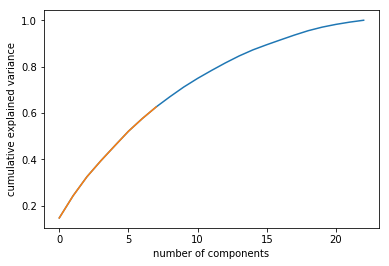

In [36]:
dtw_experiment.ReducingDimensionByPCA()

# The Dimension has been reduced to 8 features as shown below

In [37]:
dtw_experiment.get_masterset().get_data().head()

0      1      2       3       4       5       6      7  Subject  Label
0 1.4205 0.1466 0.5274 -0.3884 -0.1642 -0.6575 -0.0761 0.8688        1      1
1 1.4678 0.1331 0.5332 -0.3481 -0.1294 -0.6367 -0.0289 0.9082        1      1
2 1.4338 0.1364 0.5151 -0.3970 -0.0735 -0.6206 -0.0324 0.9351        1      1
3 1.4356 0.1508 0.5069 -0.5484  0.0502 -0.6006 -0.0575 0.8651        1      1
4 1.4311 0.1513 0.5143 -0.4502 -0.0292 -0.6181 -0.0372 0.8905        1      1

In [38]:
dtw_experiment.get_testset().get_data().head()

0      1      2      3      4       5      6      7  Subject  Label
0 0.8550 0.0165 1.5135 1.1537 0.6325 -0.5711 0.8249 0.4266        9      1
1 0.8899 0.0327 1.4287 0.6666 1.0188 -0.4945 0.7577 0.3114        9      1
2 0.8507 0.0589 1.4215 0.4509 1.1791 -0.4320 0.7531 0.2664        9      1
3 0.9129 0.0415 1.4057 0.3884 1.2249 -0.4390 0.7185 0.2142        9      1
4 0.8917 0.0446 1.3818 0.3085 1.2734 -0.4307 0.7008 0.2120        9      1

# There is nothing changed in our dataset except that the 23 features have been transformed to 8 factors

![title](img/after_dimension_reduction.png)

# Classification by Dynamic Time Warping

# We assume there is an unknown action from a test subject

# then we compare this unknown action with all actions from a master subject to get the distance by DTW

![title](img/compare_1_subject.png)

### given:
### Method = classifyOneMovement
### Test subject = 9
### Test subject action = 3
### subsample = 5 (for both masterset and testset)

### Subsample means that every 5 observations we take 1 observation as sample data

In [39]:
one_move_df = dtw_experiment.classifyOneMovement(mastersubject_index = 1
                                                  , testsubject_index = 9
                                                  , testsubject_action_index = 3
                                                  , subsample = 5)

# As a result, we find that action 3 of subject 1 has the shortest distance with this unknown action

In [40]:
one_move_df

MasterSubject  TestSubject  TestSubjectAction  MasterSetAction   Distance  \
0               1            9                  3                1 4,230.3286   
1               1            9                  3                2 3,598.9029   
2               1            9                  3                3   824.2337   
3               1            9                  3                4 3,840.2821   
4               1            9                  3                6 4,099.6649   
5               1            9                  3                7 3,502.1836   
6               1            9                  3                8 4,800.8215   
7               1            9                  3                9 3,705.4715   
8               1            9                  3               10 4,378.4223   
9               1            9                  3               11 5,772.8883   
10              1            9                  3               12 3,399.3200   
11              1            9                  3                5 4,151.3528   

    isMinDistance  isCorrect  
0          0.0000     0.0000  
1          0.0000     0.0000  
2          1.0000     1.0000  
3          0.0000     0.0000  
4          0.0000     0.0000  
5          0.0000     0.0000  
6          0.0000     0.0000  
7          0.0000     0.0000  
8          0.0000     0.0000  
9          0.0000     0.0000  
10         0.0000     0.0000  
11         0.0000     0.0000

# We compare the unknown action with all other 7 master subjects

![title](img/compare_8_subjects.png)

### given:
### Method = classifyOneMovementByAllMasterSubjects
### Test subject = 9
### Test subject action = 3
### subsample = 5 (for both masterset and testset)

In [41]:
one_move_all_df = dtw_experiment.classifyOneMovementByAllMasterSubjects(testsubject_index = 9
                                                                          , testsubject_action_index = 3
                                                                          , subsample = 5)

In [42]:
one_move_all_df

MasterSubject  TestSubject  TestSubjectAction  MasterSetAction   Distance  \
0               1            9                  3                1 4,230.3286   
1               1            9                  3                2 3,598.9029   
2               1            9                  3                3   824.2337   
3               1            9                  3                4 3,840.2821   
4               1            9                  3                6 4,099.6649   
5               1            9                  3                7 3,502.1836   
6               1            9                  3                8 4,800.8215   
7               1            9                  3                9 3,705.4715   
8               1            9                  3               10 4,378.4223   
9               1            9                  3               11 5,772.8883   
10              1            9                  3               12 3,399.3200   
11              1            9                  3                5 4,151.3528   
0               2            9                  3                1 3,504.6833   
1               2            9                  3                2 3,066.1445   
2               2            9                  3                3 2,182.6160   
3               2            9                  3                4 3,724.9262   
4               2            9                  3                6 4,827.6528   
5               2            9                  3                7 3,838.3387   
6               2            9                  3                8 5,087.6675   
7               2            9                  3                9 3,715.6202   
8               2            9                  3               10 4,380.5167   
9               2            9                  3               11 4,694.1577   
10              2            9                  3               12 4,136.8339   
11              2            9                  3                5 3,915.3139   
0               3            9                  3                1 4,073.9420   
1               3            9                  3                2 4,071.7476   
2               3            9                  3                3   644.2794   
3               3            9                  3                4 3,958.4916   
4               3            9                  3                6 4,447.1382   
5               3            9                  3                7 4,075.2326   
..            ...          ...                ...              ...        ...   
6               6            9                  3                8 4,475.7977   
7               6            9                  3                9 4,230.6530   
8               6            9                  3               10 4,973.7962   
9               6            9                  3               11 5,957.6353   
10              6            9                  3               12 3,430.1136   
11              6            9                  3                5 4,143.6441   
0               7            9                  3                1 3,481.1705   
1               7            9                  3                2 3,163.3374   
2               7            9                  3                3 2,051.6924   
3               7            9                  3                4 3,728.6039   
4               7            9                  3                6 4,159.2038   
5               7            9                  3                7 2,821.2278   
6               7            9                  3                8 4,141.4220   
7               7            9                  3                9 4,104.4691   
8               7            9                  3               10 4,827.4255   
9               7            9                  3               11 4,951.1411   
10              7            9                  3               12 3,129.1813   
11              7            9     

# We group the distance by actions and get their mean distance

# We find that action 3 has a shortest mean distance

# Therefore, we predict that the unknown action is action 3


In [43]:
one_move_all_df[['MasterSetAction','Distance']].groupby(by="MasterSetAction").mean()

Distance
MasterSetAction           
1               3,874.7335
2               3,591.8051
3               1,203.6484
4               4,074.0757
5               4,032.4908
6               4,480.4970
7               3,509.2232
8               4,515.9801
9               3,937.6668
10              4,844.3767
11              5,477.9971
12              3,730.7522

# We directly get the prediction by method called "predictOneMovement"

In [44]:
predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index = 9
                                                  , testsubject_action_index = 3
                                                  , subsample = 5)

In [45]:
predictedAction

3

In [46]:
predictedResult

True

# For validation, we repeat same steps for remaining actions of the 2 subjects in Test Set

![title](img/compare_all.png)

In [49]:
predicted_all_df, accuracy = dtw_experiment.PredictAllMovements(test_subject_index_list = [9, 10]
                                                   , test_subject_action_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
                                                   , subsample = 5)


# As a result, the overall accuracy score is 0.625

In [50]:
accuracy

0.625

In [51]:
predicted_all_df

TestSubject  ActualAction  PredictedAction  Result
0             9             1                1    True
1             9             2                7   False
2             9             3                3    True
3             9             4                4    True
4             9             5                5    True
5             9             6                8   False
6             9             7                9   False
7             9             8                9   False
8             9             9                9    True
9             9            10               10    True
10            9            11               10   False
11            9            12               12    True
12           10             1                1    True
13           10             2                2    True
14           10             3                3    True
15           10             4                4    True
16           10             5                5    True
17           10             6                8   False
18           10             7                9   False
19           10             8                9   False
20           10             9                9    True
21           10            10               10    True
22           10            11               10   False
23           10            12               12    True

2) Activity set

The activity set is listed in the following:

L1: Standing still (1 min) 
L2: Sitting and relaxing (1 min) 
L3: Lying down (1 min) 
L4: Walking (1 min) 
L5: Climbing stairs (1 min) 
L6: Waist bends forward (20x) 
L7: Frontal elevation of arms (20x)
L8: Knees bending (crouching) (20x)
L9: Cycling (1 min)
L10: Jogging (1 min)
L11: Running (1 min)
L12: Jump front & back (20x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

            Standing       1.00      1.00      1.00         2
             Sitting       1.00      0.50      0.67         2
               Lying       1.00      1.00      1.00         2
             Walking       1.00      1.00      1.00         2
            Climbing       1.00      1.00      1.00         2
   WaistBendsForward       0.00      0.00      0.00         2
FrontalEvelationArms       0.00      0.00      0.00         2
           Crouching       0.00      0.00      0.00         2
             Cycling       0.33      1.00      0.50         2
             Jogging       0.50      1.00      0.67         2
             Running       0.00      0.00      0.00         2
             Jumping       1.00      1.00      1.00         2

         avg / total       0.57      0.62      0.57        24



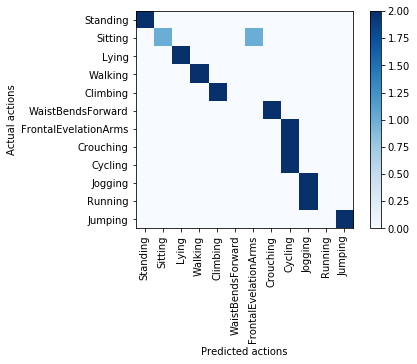

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics

columns = ['Standing', 'Sitting', 'Lying', 'Walking', 'Climbing', 'WaistBendsForward', 'FrontalEvelationArms'
          , 'Crouching','Cycling','Jogging','Running','Jumping']
confusion = metrics.confusion_matrix(predicted_all_df['ActualAction'], predicted_all_df['PredictedAction'])
print(metrics.classification_report(predicted_all_df['ActualAction'], predicted_all_df['PredictedAction'], target_names=columns))

plt.imshow(confusion, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], columns, rotation='vertical')
plt.xlabel('Predicted actions')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], columns)
plt.ylabel('Actual actions')
plt.colorbar()

plt.show()

# From the confusion matrix above, we understand that
### - DTW can be used for classification problems​

### - The actions lie on the diagonal in deep blue, DTW has good accuracy to classify it.  e.g. standing and jogging


# Deficiencies

## - Small Data Set: Only 10 people​

## - It takes time to get DTW results

# Possible Improvements

## - The accuracy can probably be improved by increasing number of subjects in master set and the number of observations used​

## - Cross validation is expected to be used​

## - Rank / weight of features according to actions

# Code for 3D armadillo case

### source: edX - Microsoft: DAT210x Programming with Python for Data Science - Lab4_1
### https://courses.edx.org/courses/course-v1:Microsoft+DAT210x+4T2017/course/

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement

plt.style.use('ggplot')

reduce_factor = 100

plyfile = PlyData.read('PCA/Datasets/stanford_armadillo.ply')

armadillo = pd.DataFrame({
  'x':plyfile['vertex']['z'][::reduce_factor],
  'y':plyfile['vertex']['x'][::reduce_factor],
  'z':plyfile['vertex']['y'][::reduce_factor]
})



In [48]:
def do_PCA(armadillo, n_components, svd_solver):
    # .. your code here ..
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=n_components, svd_solver=svd_solver)
    pca.fit(armadillo)
    T = pca.transform(armadillo)
    
    return T 

In [49]:
pca = do_PCA(armadillo, 3, 'full')

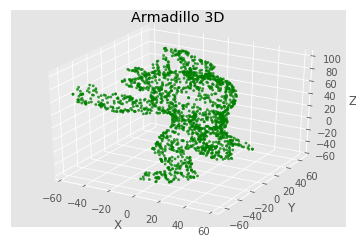

In [50]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

ax.set_title('Armadillo 3D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter(armadillo.x, armadillo.y, armadillo.z, c='green', marker='.', alpha=0.75)
plt.show()

# Get 3 images

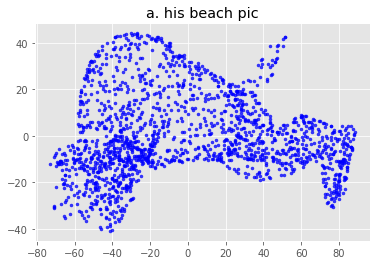

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('a. his beach pic')
ax.scatter(pca[:,0], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

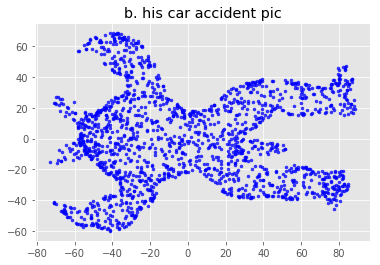

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('b. his car accident pic')
ax.scatter(pca[:,0], pca[:,1], c='blue', marker='.', alpha=0.75)
plt.show()

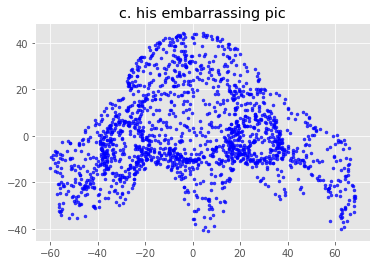

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('c. his embarrassing pic')
ax.scatter(pca[:,1], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

# get components

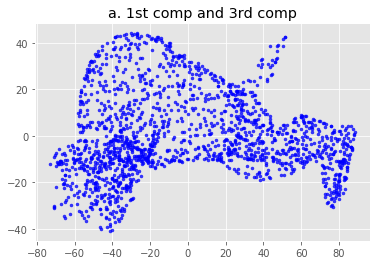

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('a. 1st comp and 3rd comp')
ax.scatter(pca[:,0], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

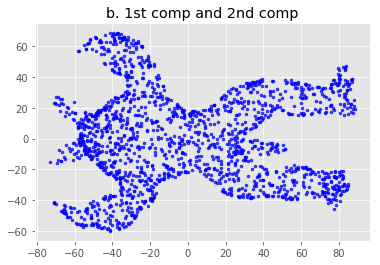

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('b. 1st comp and 2nd comp')
ax.scatter(pca[:,0], pca[:,1], c='blue', marker='.', alpha=0.75)
plt.show()

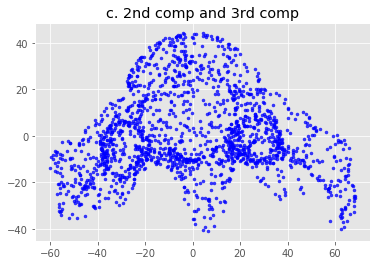

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('c. 2nd comp and 3rd comp')
ax.scatter(pca[:,1], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()